In [18]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

In [19]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import json
from PIL import Image
from glob import glob
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from skimage import transform
from torchvision import transforms
import random
from torch.utils.data import DataLoader

In [21]:
class AverageMeter(object):
    """Computes and stores the average and current value
    https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """

        Args:
            val: mini-batch loss or accuracy value
            n: mini-batch size
        """
        self.val = val
        self.sum += val 
        self.count += n
        self.avg = self.sum / self.count

In [22]:
#all_disaster_splits_json_filename = './all_disaster_splits.json'
all_disaster_splits_json_filename = '../constants/splits/final_mdl_all_disaster_splits.json'
label_map_json_file = '../constants/class_lists/xBD_label_map.json'

def load_json_files(json_filename):
    with open(json_filename) as f:
        file_content = json.load(f)
    return file_content

splits = load_json_files(all_disaster_splits_json_filename)
label_map = load_json_files(label_map_json_file)

In [23]:
# get list of train, val, test images
splits.keys()
all_images_ls = [] 
for item, val in splits.items():
    all_images_ls += val['train'] 
    all_images_ls += val['test'] 
    all_images_ls += val['val'] 


len(all_images_ls)
all_images_ls[1:20]

dict_keys(['guatemala-volcano', 'hurricane-matthew', 'mexico-earthquake'])

626

['raw/hold/labels/guatemala-volcano_00000012',
 'raw/hold/labels/guatemala-volcano_00000014',
 'raw/hold/labels/guatemala-volcano_00000020',
 'raw/hold/labels/guatemala-volcano_00000022',
 'raw/test/labels/guatemala-volcano_00000003',
 'raw/test/labels/guatemala-volcano_00000009',
 'raw/test/labels/guatemala-volcano_00000011',
 'raw/test/labels/guatemala-volcano_00000021',
 'raw/train/labels/guatemala-volcano_00000000',
 'raw/train/labels/guatemala-volcano_00000001',
 'raw/train/labels/guatemala-volcano_00000002',
 'raw/train/labels/guatemala-volcano_00000006',
 'raw/train/labels/guatemala-volcano_00000008',
 'raw/train/labels/guatemala-volcano_00000013',
 'raw/train/labels/guatemala-volcano_00000015',
 'raw/train/labels/guatemala-volcano_00000016',
 'raw/train/labels/guatemala-volcano_00000017',
 'raw/train/labels/guatemala-volcano_00000018',
 'raw/train/labels/guatemala-volcano_00000019']

In [24]:
class DisasterDataset_img(Dataset):
    def __init__(self, data_dir, data_dir_ls, transform:bool, scale=1, mask_suffix=''):
        
        self.data_dir = data_dir
        self.dataset_sub_dir = data_dir_ls
        self.scale = scale
        self.transform = transform
        
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

    def __len__(self):
        return len(self.dataset_sub_dir)
        
        return img_trans
    
    
    def __getitem__(self, i):
        
        imgs_dir = self.data_dir + self.dataset_sub_dir[i].replace('labels', 'images')

        idx = imgs_dir
        
        pre_img_file_name = imgs_dir + '_pre_disaster'
        pre_img_file = glob(pre_img_file_name + '.*')

        post_img_file_name = pre_img_file_name.replace('pre', 'post')
        post_img_file = glob(post_img_file_name + '.*')

        assert len(pre_img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {pre_img_file}'
        assert len(post_img_file) == 1, \
            f'Either no post disaster image or multiple images found for the ID {idx}: {post_img_file}'

        pre_img = np.array(Image.open(pre_img_file[0]))
        post_img = np.array(Image.open(post_img_file[0]))

        assert pre_img.size == post_img.size, \
            f'Pre_ & _post disaster Images {idx} should be the same size, but are {pre_img.size} and {post_img.size}'

        return {'pre_image': pre_img, 'post_image': post_img}, {'pre_img_file_name': pre_img_file_name, 'post_img_file_name':post_img_file_name}

In [25]:
# compute mean

mean_c1 = AverageMeter()
mean_c2 = AverageMeter()
mean_c3 = AverageMeter()

#data_dir = './xBD_all/' 
data_dir = '../../splits/final_mdl_all_disaster_splits/'
xBD_all = DisasterDataset_img(data_dir, all_images_ls, transform=True)
print('xBD_disaster_dataset length: {}'.format(len(xBD_all)))

for batch_idx, data in enumerate(xBD_all):

    data = data[0]
    x_pre = data['pre_image']
    x_post = data['post_image']
    
    mean_c1.update(x_pre[:,:,0].sum(), x_pre[:,:,0].size)
    mean_c1.update(x_post[:,:,0].sum(), x_post[:,:,0].size)

    mean_c2.update(x_pre[:,:,1].sum(), x_pre[:,:,1].size)
    mean_c2.update(x_post[:,:,1].sum(), x_post[:,:,1].size)

    mean_c3.update(x_pre[:,:,2].sum(), x_pre[:,:,2].size)
    mean_c3.update(x_post[:,:,2].sum(), x_post[:,:,2].size)


mean_c1.avg
mean_c2.avg
mean_c3.avg

xBD_disaster_dataset length: 626


83.72342045162432

92.20505311085394

66.50421923798875

In [26]:
# compute stddev

stddev_c1 = AverageMeter()
stddev_c2 = AverageMeter()
stddev_c3 = AverageMeter()


for batch_idx, data in enumerate(xBD_all):
    data = data[0]

    x_pre = data['pre_image']
    x_post = data['post_image']
    
    diff_pre = np.power(x_pre[:,:,0] - mean_c1.avg, 2.0) 
    diff_post = np.power(x_post[:,:,0] - mean_c1.avg, 2.0) 
    stddev_c1.update(diff_pre.sum(), diff_pre.size)
    stddev_c1.update(diff_post.sum(), diff_post.size)

    diff_pre = np.power(x_pre[:,:,1] - mean_c2.avg, 2.0) 
    diff_post = np.power(x_post[:,:,1] - mean_c2.avg, 2.0) 
    stddev_c2.update(diff_pre.sum(), diff_pre.size)
    stddev_c2.update(diff_post.sum(), diff_post.size)

    diff_pre = np.power(x_pre[:,:,2] - mean_c3.avg, 2.0) 
    diff_post = np.power(x_post[:,:,2] - mean_c3.avg, 2.0)
    stddev_c3.update(diff_pre.sum(), diff_pre.size)
    stddev_c3.update(diff_post.sum(), diff_post.size)


stddev_c1.avg ** 0.5
stddev_c2.avg ** 0.5
stddev_c3.avg ** 0.5

40.078274006754725

36.16795599937127

35.052334728431674

In [27]:
# save as json

mean_stdev_dict = {'mean':{'c1': mean_c1.avg, 'c2': mean_c2.avg, 'c3': mean_c3.avg},
              'std_dev':{'c1': stddev_c1.avg** 0.5, 'c2': stddev_c2.avg** 0.5, 'c3': stddev_c3.avg** 0.5}}
mean_stdev_dict

with open('../constants/splits/all_disaster_mean_stddev.json', 'w') as f:
    json.dump(mean_stdev_dict, f, indent=4)

{'mean': {'c1': 83.72342045162432,
  'c2': 92.20505311085394,
  'c3': 66.50421923798875},
 'std_dev': {'c1': 40.078274006754725,
  'c2': 36.16795599937127,
  'c3': 35.052334728431674}}

In [28]:
# test a few things

type(x_post)
x_pre.shape

x_pre[:,:,0].size
x_pre[:,:,0].shape
x_pre[:,:,0].sum()

x_pre[:,:,0] - mean_c1.avg
out = np.power(x_pre[:,:,0] - mean_c1.avg, 2.0) 
out.sum()
out.size


numpy.ndarray

(1024, 1024, 3)

1048576

(1024, 1024)

73240303

array([[ 30.27657955,  15.27657955,  19.27657955, ...,  -5.72342045,
        -11.72342045,  -5.72342045],
       [ 54.27657955,  -1.72342045,  16.27657955, ..., -14.72342045,
         -9.72342045,  -3.72342045],
       [ 56.27657955,  -4.72342045,  16.27657955, ..., -20.72342045,
        -21.72342045, -12.72342045],
       ...,
       [-83.72342045, -83.72342045, -83.72342045, ..., -83.72342045,
        -83.72342045, -83.72342045],
       [-83.72342045, -83.72342045, -83.72342045, ..., -83.72342045,
        -83.72342045, -83.72342045],
       [-83.72342045, -83.72342045, -83.72342045, ..., -83.72342045,
        -83.72342045, -83.72342045]])

4268129385.3265843

1048576

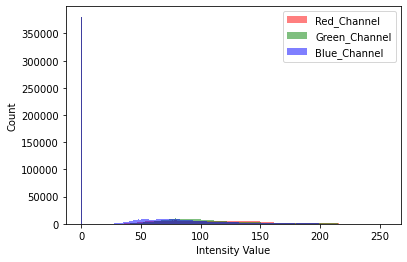

In [29]:
# plot histogram of the channels for one image #entire dataset
from skimage import io
import matplotlib.pyplot as plt
image = x_pre
_ = plt.hist(image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

# Compute mean & stddev for each tile

In [30]:
# compute mean actual values

mean_std_tile = {}

xBD_all = DisasterDataset_img(data_dir, all_images_ls, transform=True)
print('xBD_disaster_dataset length: {}'.format(len(xBD_all)))

for batch_idx, data in enumerate(xBD_all):
    
    x_pre = data[0]['pre_image']
    x_post = data[0]['post_image']
    x_pre_filename = data[1]['pre_img_file_name'].replace('xBD', 'xBD_sliced')
    x_post_filename = data[1]['post_img_file_name'].replace('xBD', 'xBD_sliced')
    
    mean_std_tile[x_pre_filename]=[(x_pre[:,:,0].mean(), x_pre[:,:,1].mean(), x_pre[:,:,2].mean()), (x_pre[:,:,0].std(), x_pre[:,:,1].std(), x_pre[:,:,2].std())]
    mean_std_tile[x_post_filename]= [(x_post[:,:,0].mean(), x_post[:,:,1].mean(), x_post[:,:,2].mean()), (x_post[:,:,0].std(), x_post[:,:,1].std(), x_post[:,:,2].std())]

with open('../constants/splits/all_disaster_mean_stddev_tiles.json', 'w') as f:
    json.dump(mean_std_tile, f, indent=4)

xBD_disaster_dataset length: 626


In [31]:
# compute mean [0,1]

mean_std_tile = {}
eps = np.finfo(float).eps
xBD_all = DisasterDataset_img(data_dir, all_images_ls, transform=True)
print('xBD_disaster_dataset length: {}'.format(len(xBD_all)))

for batch_idx, data in enumerate(xBD_all):
    
    x_pre = data[0]['pre_image']/255.0
    x_post = data[0]['post_image']/255.0
    x_pre_filename = data[1]['pre_img_file_name'].replace('xBD', 'xBD_sliced')
    x_post_filename = data[1]['post_img_file_name'].replace('xBD', 'xBD_sliced')
    
    mean_std_tile[x_pre_filename]=[(x_pre[:,:,0].mean(), x_pre[:,:,1].mean(), x_pre[:,:,2].mean()), (max(eps, x_pre[:,:,0].std()), max(eps, x_pre[:,:,1].std()), max(eps, x_pre[:,:,2].std()))]
    mean_std_tile[x_post_filename]= [(x_post[:,:,0].mean(), x_post[:,:,1].mean(), x_post[:,:,2].mean()), (x_post[:,:,0].std(), x_post[:,:,1].std(), x_post[:,:,2].std())]

with open('../constants/splits/all_disaster_mean_stddev_tiles_0_1.json', 'w') as f:
    json.dump(mean_std_tile, f, indent=4)

xBD_disaster_dataset length: 626


In [32]:
eps = np.finfo(float).eps
0/eps

0.0

In [33]:
# test a few things
from torchvision import transforms

mean_std_tile = {}

xBD_all = DisasterDataset_img(data_dir, all_images_ls, transform=True)
print('xBD_disaster_dataset length: {}'.format(len(xBD_all)))

for batch_idx, data in enumerate(xBD_all):
    
    x_pre = data[0]['pre_image']
    x_post = data[0]['post_image']
    x_pre_filename = data[1]['pre_img_file_name'].replace('xBD', 'xBD_sliced')
    x_post_filename = data[1]['post_img_file_name'].replace('xBD', 'xBD_sliced')
    
    mean_std_tile[x_pre_filename]=[(x_pre[:,:,0].mean(), x_pre[:,:,1].mean(), x_pre[:,:,2].mean()), (x_pre[:,:,0].std(), x_pre[:,:,1].std(), x_pre[:,:,2].std())]
    mean_std_tile[x_post_filename]= [(x_post[:,:,0].mean(), x_post[:,:,1].mean(), x_post[:,:,2].mean()), (x_post[:,:,0].std(), x_post[:,:,1].std(), x_post[:,:,2].std())]
    
    mean_pre = mean_std_tile[x_pre_filename][0]
    stddev_pre = mean_std_tile[x_pre_filename][1]
    mean_pre
    stddev_pre
    norm_pre = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_pre, std=stddev_pre),
    ])
    make_img_pre = transforms.Compose([
                transforms.ToTensor(),
                transforms.ToPILImage()])
    x_pre
    pre_img = norm_pre(x_pre)
    pre_img
    break

xBD_disaster_dataset length: 626


(92.60825061798096, 112.36695575714111, 81.91974258422852)

(45.83748581915052, 42.44392837800163, 50.27911567645592)

array([[[ 81, 101,  56],
        [ 80,  99,  55],
        [ 75,  97,  54],
        ...,
        [198, 212, 210],
        [199, 214, 211],
        [199, 213, 211]],

       [[ 83, 105,  58],
        [ 81, 102,  57],
        [ 75,  97,  54],
        ...,
        [201, 216, 214],
        [200, 215, 213],
        [201, 216, 214]],

       [[ 77, 100,  54],
        [ 78, 101,  55],
        [ 73,  97,  52],
        ...,
        [197, 212, 210],
        [198, 213, 211],
        [198, 213, 210]],

       ...,

       [[ 37,  56,  38],
        [ 32,  51,  33],
        [ 42,  62,  40],
        ...,
        [135, 154, 133],
        [131, 150, 129],
        [133, 152, 131]],

       [[ 39,  57,  38],
        [ 27,  43,  27],
        [ 26,  42,  26],
        ...,
        [132, 151, 130],
        [129, 148, 127],
        [133, 151, 131]],

       [[ 26,  42,  26],
        [ 32,  49,  32],
        [ 28,  44,  28],
        ...,
        [127, 147, 126],
        [131, 150, 129],
        [125, 146, 125]]

tensor([[[-2.0134, -2.0135, -2.0139,  ..., -2.0034, -2.0033, -2.0033],
         [-2.0133, -2.0134, -2.0139,  ..., -2.0032, -2.0032, -2.0032],
         [-2.0138, -2.0137, -2.0141,  ..., -2.0035, -2.0034, -2.0034],
         ...,
         [-2.0172, -2.0176, -2.0168,  ..., -2.0088, -2.0092, -2.0090],
         [-2.0170, -2.0181, -2.0181,  ..., -2.0091, -2.0093, -2.0090],
         [-2.0181, -2.0176, -2.0180,  ..., -2.0095, -2.0092, -2.0097]],

        [[-2.6381, -2.6383, -2.6385,  ..., -2.6278, -2.6276, -2.6277],
         [-2.6377, -2.6380, -2.6385,  ..., -2.6275, -2.6276, -2.6275],
         [-2.6382, -2.6381, -2.6385,  ..., -2.6278, -2.6277, -2.6277],
         ...,
         [-2.6422, -2.6427, -2.6417,  ..., -2.6332, -2.6336, -2.6334],
         [-2.6422, -2.6434, -2.6435,  ..., -2.6335, -2.6337, -2.6335],
         [-2.6435, -2.6429, -2.6434,  ..., -2.6338, -2.6336, -2.6339]],

        [[-1.6249, -1.6250, -1.6251,  ..., -1.6129, -1.6128, -1.6128],
         [-1.6248, -1.6249, -1.6251,  ..., -1

In [34]:
max(0,10)

10